## Deep learning methods

In [1]:
import tensorflow as tf
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

### Loading the data

In [2]:
preprocessed_df = joblib.load("preprocessed_df.pkl")
label_names = preprocessed_df.columns[3:-1]
y_train = joblib.load('y_train.pkl')
y_test = joblib.load("y_test.pkl")
embeddings_train = joblib.load("sequences_train.pkl")
embeddings_tests = joblib.load("sequences_test.pkl")
tfidf_train = joblib.load("tfidf_train.pkl")
tfidf_test = joblib.load("tfidf_test.pkl")
sense_train = joblib.load("sense_vectors_train.pkl")
sense_test = joblib.load("sense_vectors_test.pkl")
print(label_names)
print(y_train.shape)

Index(['related', 'request', 'offer', 'aid_related', 'medical_help',
       'medical_products', 'search_and_rescue', 'security', 'military',
       'water', 'food', 'shelter', 'clothing', 'money', 'missing_people',
       'refugees', 'death', 'other_aid', 'infrastructure_related', 'transport',
       'buildings', 'electricity', 'tools', 'hospitals', 'shops',
       'aid_centers', 'other_infrastructure', 'weather_related', 'floods',
       'storm', 'fire', 'earthquake', 'cold', 'other_weather',
       'direct_report'],
      dtype='object')
(20972, 35)


### Deep models

Small LSTM model for embeddings and small dense model for TF-IDF features

In [3]:
def dense_model(input_shape, output_dim, dense_dim):
    inp = tf.keras.Input(input_shape[1:])
    x = tf.keras.layers.Dense(dense_dim, activation="relu")(inp)
    x = tf.keras.layers.Dropout(0.2)(x)
    output = tf.keras.layers.Dense(output_dim, activation="sigmoid")(x)
    return tf.keras.Model(inputs = inp, outputs = output)

def lstm_model(input_shape, output_dim, lstm_dim: int = 256, embedding_dim: int = None, vocabulary: int = 5000):
    inp = tf.keras.layers.Input(input_shape[1:])
    x = inp
    if embedding_dim:
        x = tf.keras.layers.Embedding(vocabulary, embedding_dim, mask_zero=True)(x)
    else:
        x = tf.keras.layers.Masking()(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim, return_sequences=False), merge_mode="sum")(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(lstm_dim//2, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    output = tf.keras.layers.Dense(output_dim, activation="sigmoid")(x)
    return tf.keras.Model(inputs = inp, outputs = output)

model_dense = dense_model(input_shape=tfidf_train.shape, output_dim=y_train.shape[1], dense_dim=128)
model_lstm = lstm_model(embeddings_train.shape, output_dim=y_train.shape[1])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6224)]            0         
                                                                 
 dense (Dense)               (None, 128)               796800    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 35)                4515      
                                                                 
Total params: 801,315
Trainable params: 801,315
Non-trainable params: 0
_________________________________________________________________


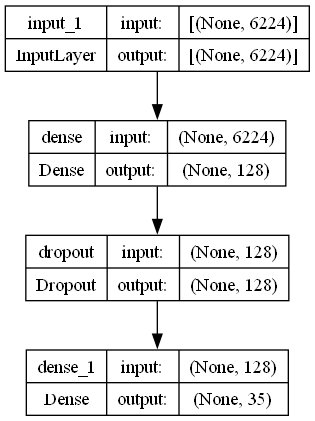

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50, 50)]          0         
                                                                 
 masking (Masking)           (None, 50, 50)            0         
                                                                 
 bidirectional (Bidirectiona  (None, 256)              628736    
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                           

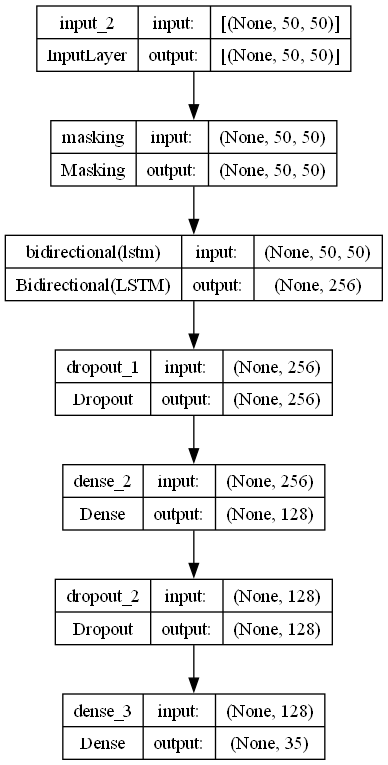

In [4]:
model_dense.summary()
display(tf.keras.utils.plot_model(model_dense, show_shapes=True))
model_lstm.summary()
display(tf.keras.utils.plot_model(model_lstm, show_shapes=True))

### TF-IDF vectors on dense model

In [5]:
tfidf_train_tensors = tf.data.Dataset.from_tensor_slices((tfidf_train.toarray(), y_train)).batch(16).prefetch(tf.data.AUTOTUNE)
tfidf_test_tensors = tf.data.Dataset.from_tensor_slices((tfidf_test.toarray(), y_test)).batch(16).prefetch(tf.data.AUTOTUNE)

In [6]:
model_dense.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics = tf.keras.metrics.AUC(multi_label=True))
history = model_dense.fit(tfidf_train_tensors, validation_data = tfidf_test_tensors, epochs = 5)

Epoch 1/5
1311/1311 [==============================] - 11s 7ms/step - loss: 0.2175 - auc: 0.6732 - val_loss: 0.1669 - val_auc: 0.8007
Epoch 2/5
1311/1311 [==============================] - 9s 7ms/step - loss: 0.1485 - auc: 0.8491 - val_loss: 0.1528 - val_auc: 0.8319
Epoch 3/5
1311/1311 [==============================] - 10s 7ms/step - loss: 0.1292 - auc: 0.8958 - val_loss: 0.1499 - val_auc: 0.8395
Epoch 4/5
1311/1311 [==============================] - 10s 8ms/step - loss: 0.1163 - auc: 0.9221 - val_loss: 0.1512 - val_auc: 0.8409
Epoch 5/5
1311/1311 [==============================] - 11s 8ms/step - loss: 0.1056 - auc: 0.9417 - val_loss: 0.1547 - val_auc: 0.8348


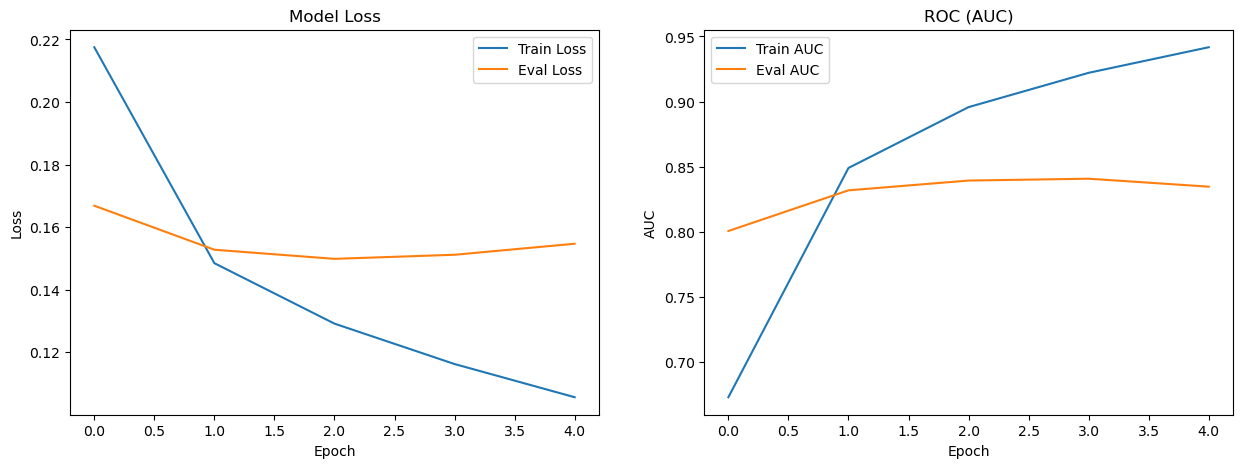

                        precision    recall  f1-score   support

               related       0.86      0.92      0.89      4018
               request       0.74      0.64      0.68       911
                 offer        nan      0.00      0.00        21
           aid_related       0.74      0.72      0.73      2232
          medical_help       0.58      0.29      0.39       438
      medical_products       0.69      0.28      0.40       265
     search_and_rescue       0.68      0.14      0.23       152
              security       0.33      0.01      0.02        82
              military       0.70      0.42      0.52       166
                 water       0.77      0.52      0.62       345
                  food       0.81      0.71      0.76       607
               shelter       0.73      0.52      0.60       465
              clothing       0.59      0.32      0.41        82
                 money       0.61      0.16      0.25       120
        missing_people       1.00      

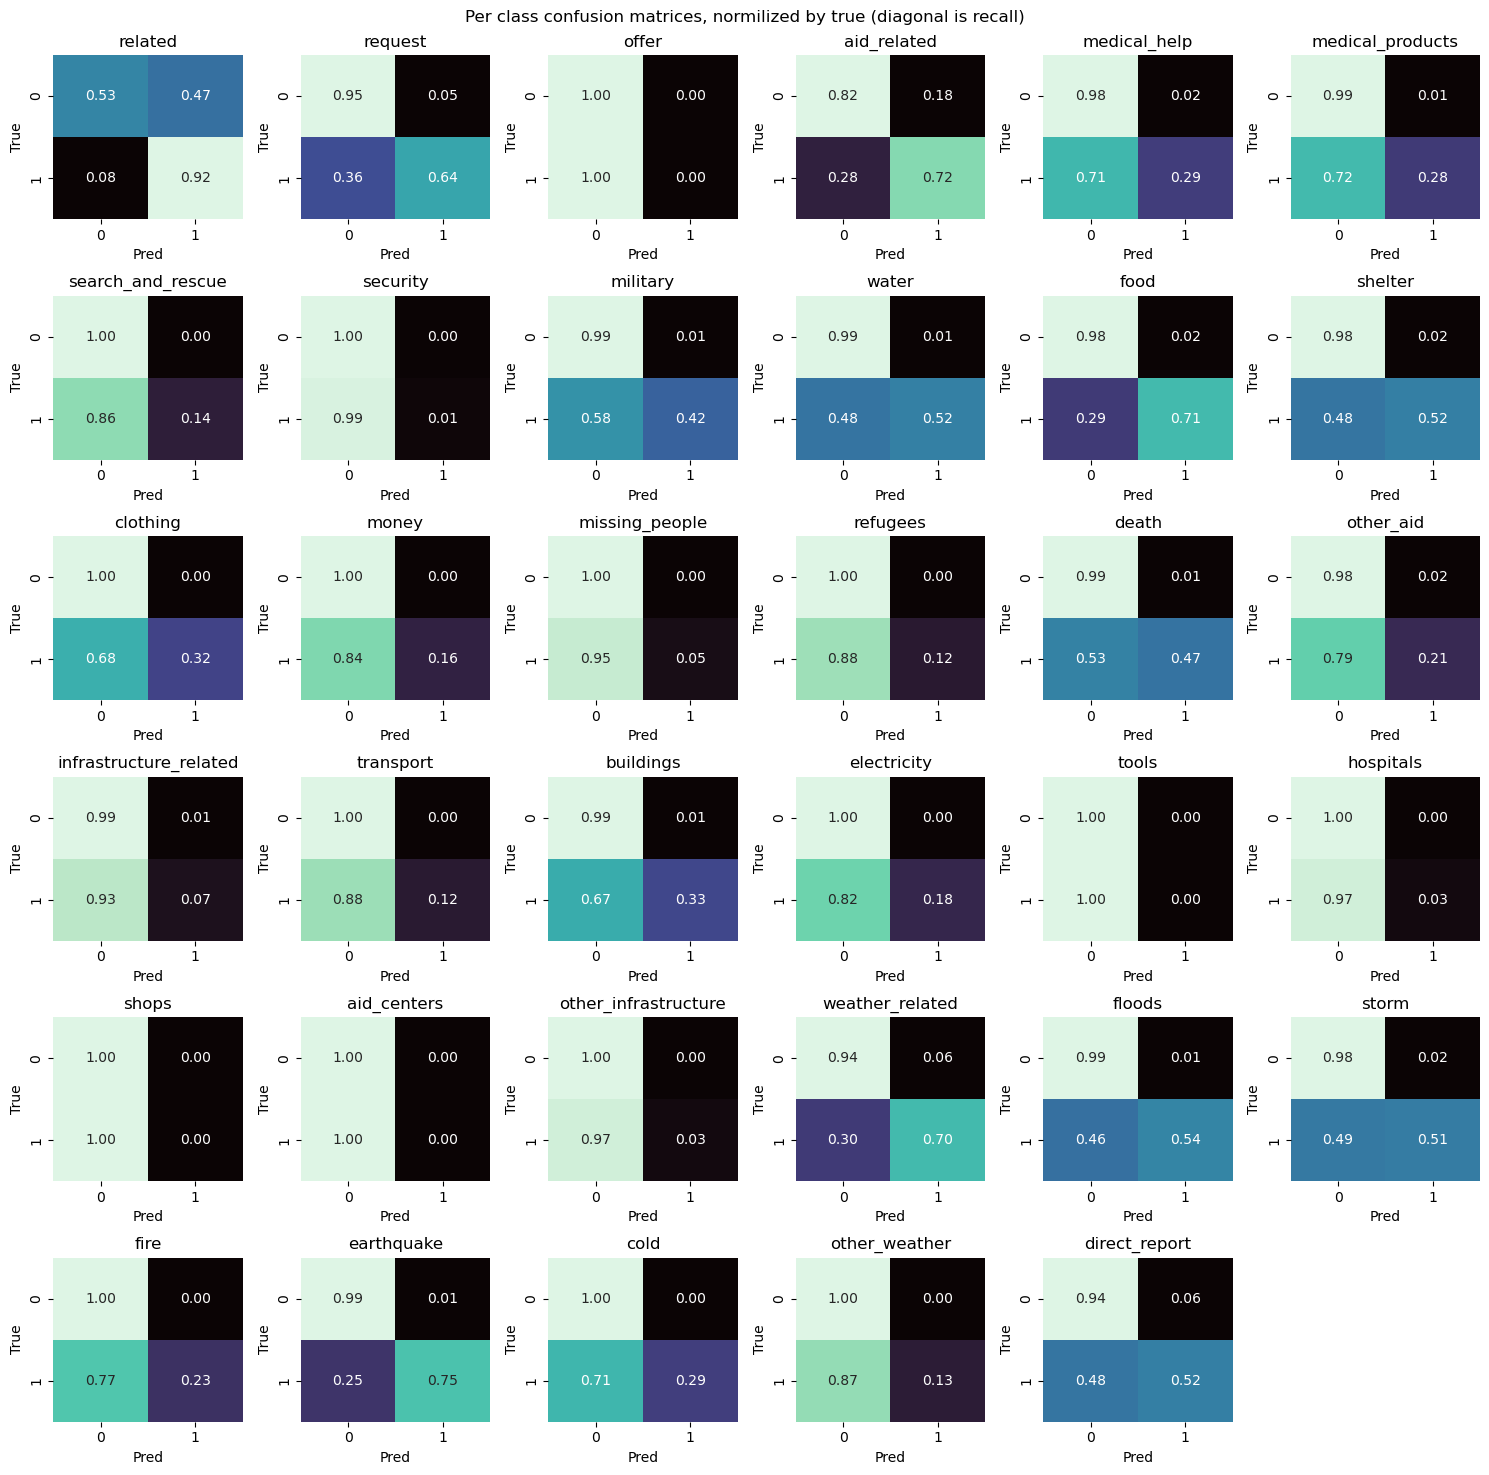

In [7]:
def results(history, epochs, prefix = ""):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    auc = history.history[f'auc{prefix}']
    val_auc =  history.history[f'val_auc{prefix}']

    def plot_history(data_1, data_2, label, subplot, title):
        x = np.arange(epochs)
        plt.subplot(1, 2, subplot)
        plt.plot(x, data_1, label = f"Train {label}")
        plt.plot(x, data_2, label = f"Eval {label}")
        plt.xlabel("Epoch")
        plt.ylabel(label)
        plt.legend()
        plt.title(title)

    plt.figure(figsize = (15, 5))
    plot_history(loss, val_loss, "Loss", 1, "Model Loss")
    plot_history(auc, val_auc, "AUC", 2, "ROC (AUC)")
    plt.show()

results(history, 5,  "")
def eval_model(test_x, test_y, labels, model,):
    preds = model.predict(test_x, verbose = 0)
    preds = (preds > 0.5).astype(np.int32).squeeze()
    cr = classification_report(test_y, preds, target_names = labels, zero_division=np.nan)
    print(cr)
    def plot_cms(y_test, preds, labels):
        plt.figure(figsize=(15,15))
        for i in range(len(labels)):
            plt.subplot(6,6,i+1)
            plt.title(f"{labels[i]}")
            cm = confusion_matrix(y_test[:, i], preds[:, i], normalize = "true")
            sns.heatmap(cm, annot=True, fmt=".2f", cbar=False, cmap="mako")
            plt.ylabel("True")
            plt.xlabel("Pred")
        plt.tight_layout()
        plt.suptitle("Per class confusion matrices, normilized by true (diagonal is recall)")
        plt.subplots_adjust(top=0.95)
        plt.show()
    plot_cms(test_y, preds, labels)

eval_model(tfidf_test.toarray(), y_test, label_names, model_dense)

### Sense embeddings

In [8]:
sense_train_tensors = tf.data.Dataset.from_tensor_slices((sense_train, y_train)).batch(16).prefetch(tf.data.AUTOTUNE)
sense_test_tensors = tf.data.Dataset.from_tensor_slices((sense_test, y_test)).batch(16).prefetch(tf.data.AUTOTUNE)

In [9]:
model_dense = dense_model(input_shape=sense_train.shape, output_dim=y_train.shape[1], dense_dim=256)
model_dense.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics = tf.keras.metrics.AUC(multi_label=True))
history = model_dense.fit(sense_train_tensors , validation_data = sense_test_tensors, epochs = 10)

Epoch 1/10
1311/1311 [==============================] - 10s 7ms/step - loss: 0.1974 - auc_1: 0.7178 - val_loss: 0.1724 - val_auc_1: 0.8015
Epoch 2/10
1311/1311 [==============================] - 9s 7ms/step - loss: 0.1661 - auc_1: 0.8086 - val_loss: 0.1650 - val_auc_1: 0.8260
Epoch 3/10
1311/1311 [==============================] - 9s 7ms/step - loss: 0.1608 - auc_1: 0.8267 - val_loss: 0.1615 - val_auc_1: 0.8348
Epoch 4/10
1311/1311 [==============================] - 10s 8ms/step - loss: 0.1579 - auc_1: 0.8336 - val_loss: 0.1593 - val_auc_1: 0.8392
Epoch 5/10
1311/1311 [==============================] - 10s 7ms/step - loss: 0.1561 - auc_1: 0.8375 - val_loss: 0.1579 - val_auc_1: 0.8425
Epoch 6/10
1311/1311 [==============================] - 9s 7ms/step - loss: 0.1544 - auc_1: 0.8435 - val_loss: 0.1569 - val_auc_1: 0.8444
Epoch 7/10
1311/1311 [==============================] - 9s 7ms/step - loss: 0.1533 - auc_1: 0.8459 - val_loss: 0.1561 - val_auc_1: 0.8451
Epoch 8/10
1311/1311 [=========

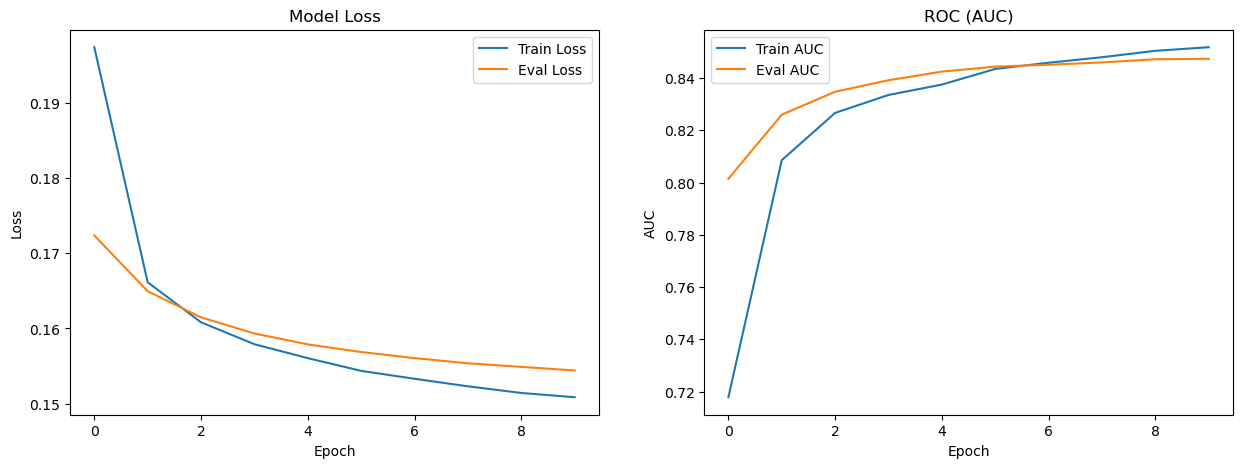

                        precision    recall  f1-score   support

               related       0.84      0.95      0.89      4018
               request       0.74      0.65      0.69       911
                 offer        nan      0.00      0.00        21
           aid_related       0.71      0.75      0.73      2232
          medical_help       0.58      0.26      0.36       438
      medical_products       0.61      0.16      0.25       265
     search_and_rescue       0.67      0.03      0.05       152
              security        nan      0.00      0.00        82
              military       0.63      0.36      0.46       166
                 water       0.80      0.44      0.57       345
                  food       0.76      0.63      0.69       607
               shelter       0.71      0.45      0.55       465
              clothing       0.64      0.17      0.27        82
                 money       0.64      0.07      0.13       120
        missing_people        nan      

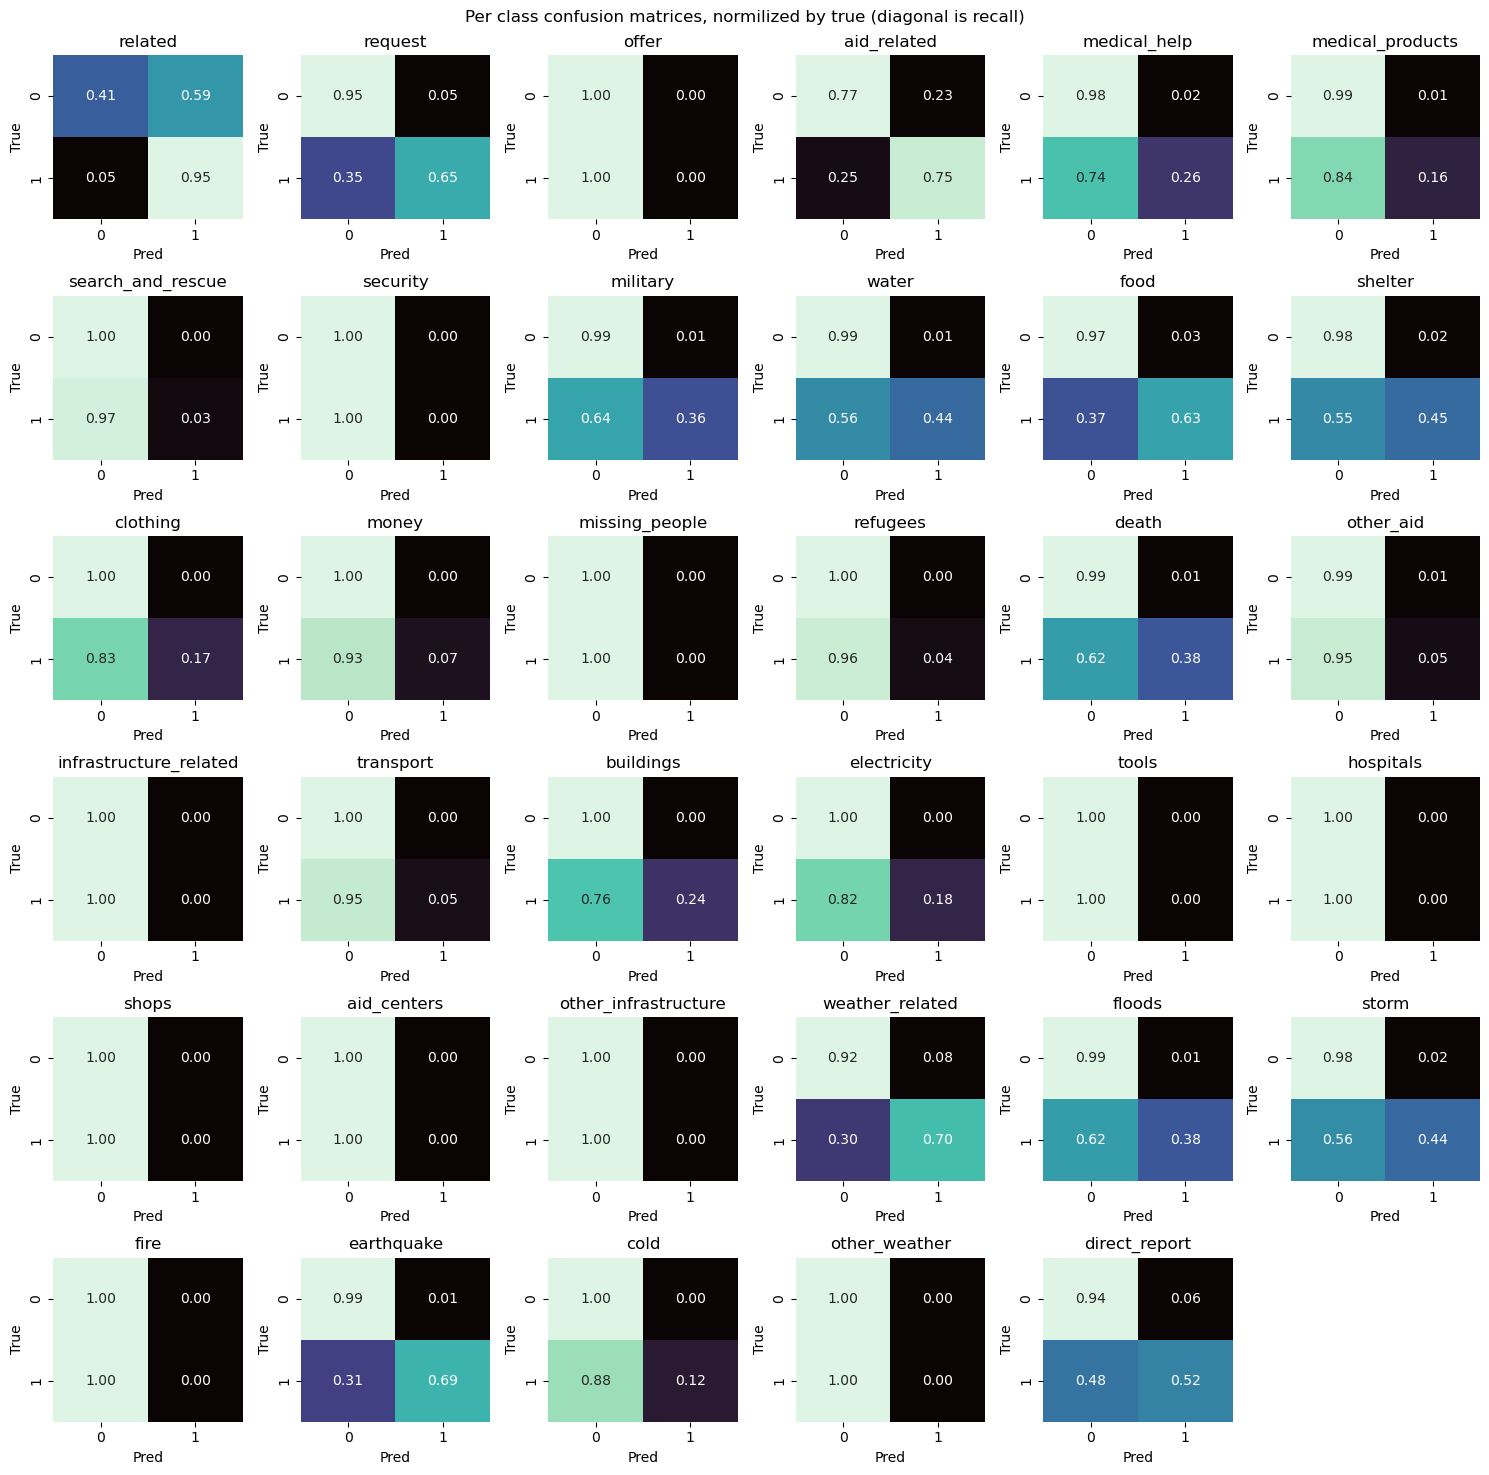

In [10]:
results(history, 10,  "_1")
eval_model(sense_test, y_test, label_names, model_dense)

## LSTM model on word2vec embeddings

In [11]:
embeddings_train_tensors = tf.data.Dataset.from_tensor_slices((embeddings_train, y_train)).batch(16).prefetch(tf.data.AUTOTUNE)
embeddings_test_tensors = tf.data.Dataset.from_tensor_slices((embeddings_tests, y_test)).batch(16).prefetch(tf.data.AUTOTUNE)

In [12]:
model_lstm = lstm_model(embeddings_train.shape, output_dim=y_train.shape[1])

In [13]:
model_lstm.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), loss = tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics = tf.keras.metrics.AUC(multi_label=True))
history = model_lstm.fit(embeddings_train_tensors, validation_data = embeddings_test_tensors , epochs = 10)

Epoch 1/10
1311/1311 [==============================] - 53s 33ms/step - loss: 0.2402 - auc_2: 0.6351 - val_loss: 0.1805 - val_auc_2: 0.7721
Epoch 2/10
1311/1311 [==============================] - 41s 31ms/step - loss: 0.1799 - auc_2: 0.7651 - val_loss: 0.1693 - val_auc_2: 0.8013
Epoch 3/10
1311/1311 [==============================] - 42s 32ms/step - loss: 0.1699 - auc_2: 0.7895 - val_loss: 0.1642 - val_auc_2: 0.8136
Epoch 4/10
1311/1311 [==============================] - 42s 32ms/step - loss: 0.1640 - auc_2: 0.8074 - val_loss: 0.1606 - val_auc_2: 0.8226
Epoch 5/10
1311/1311 [==============================] - 42s 32ms/step - loss: 0.1606 - auc_2: 0.8156 - val_loss: 0.1583 - val_auc_2: 0.8297
Epoch 6/10
1311/1311 [==============================] - 42s 32ms/step - loss: 0.1576 - auc_2: 0.8236 - val_loss: 0.1564 - val_auc_2: 0.8331
Epoch 7/10
1311/1311 [==============================] - 42s 32ms/step - loss: 0.1551 - auc_2: 0.8299 - val_loss: 0.1551 - val_auc_2: 0.8391
Epoch 8/10
1311/1311

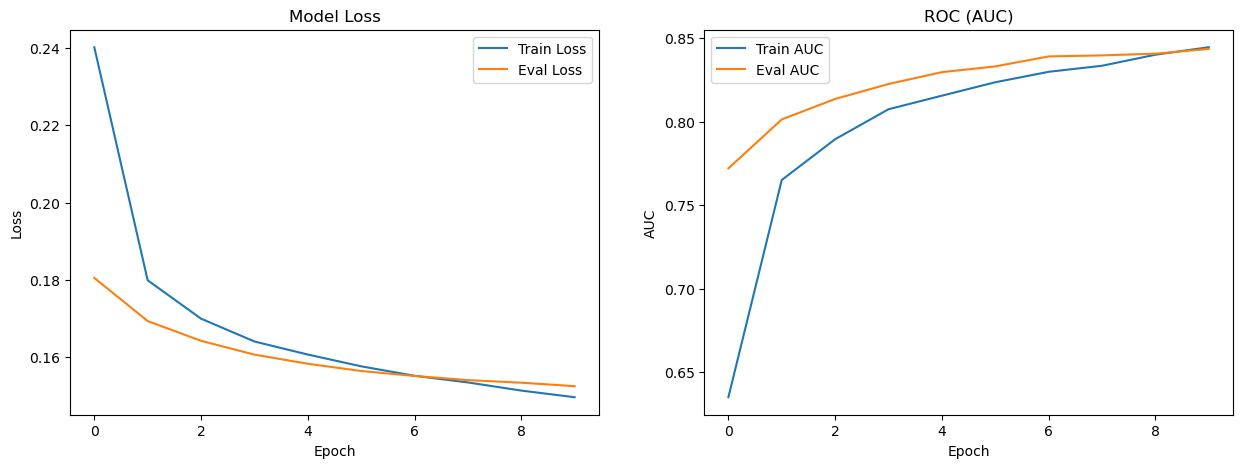

                        precision    recall  f1-score   support

               related       0.85      0.94      0.89      4018
               request       0.76      0.63      0.69       911
                 offer        nan      0.00      0.00        21
           aid_related       0.73      0.75      0.74      2232
          medical_help       0.57      0.25      0.35       438
      medical_products       0.54      0.21      0.30       265
     search_and_rescue       0.00      0.00      0.00       152
              security        nan      0.00      0.00        82
              military       0.60      0.36      0.45       166
                 water       0.80      0.51      0.62       345
                  food       0.78      0.68      0.73       607
               shelter       0.74      0.48      0.58       465
              clothing       0.54      0.16      0.25        82
                 money       0.40      0.02      0.03       120
        missing_people        nan      

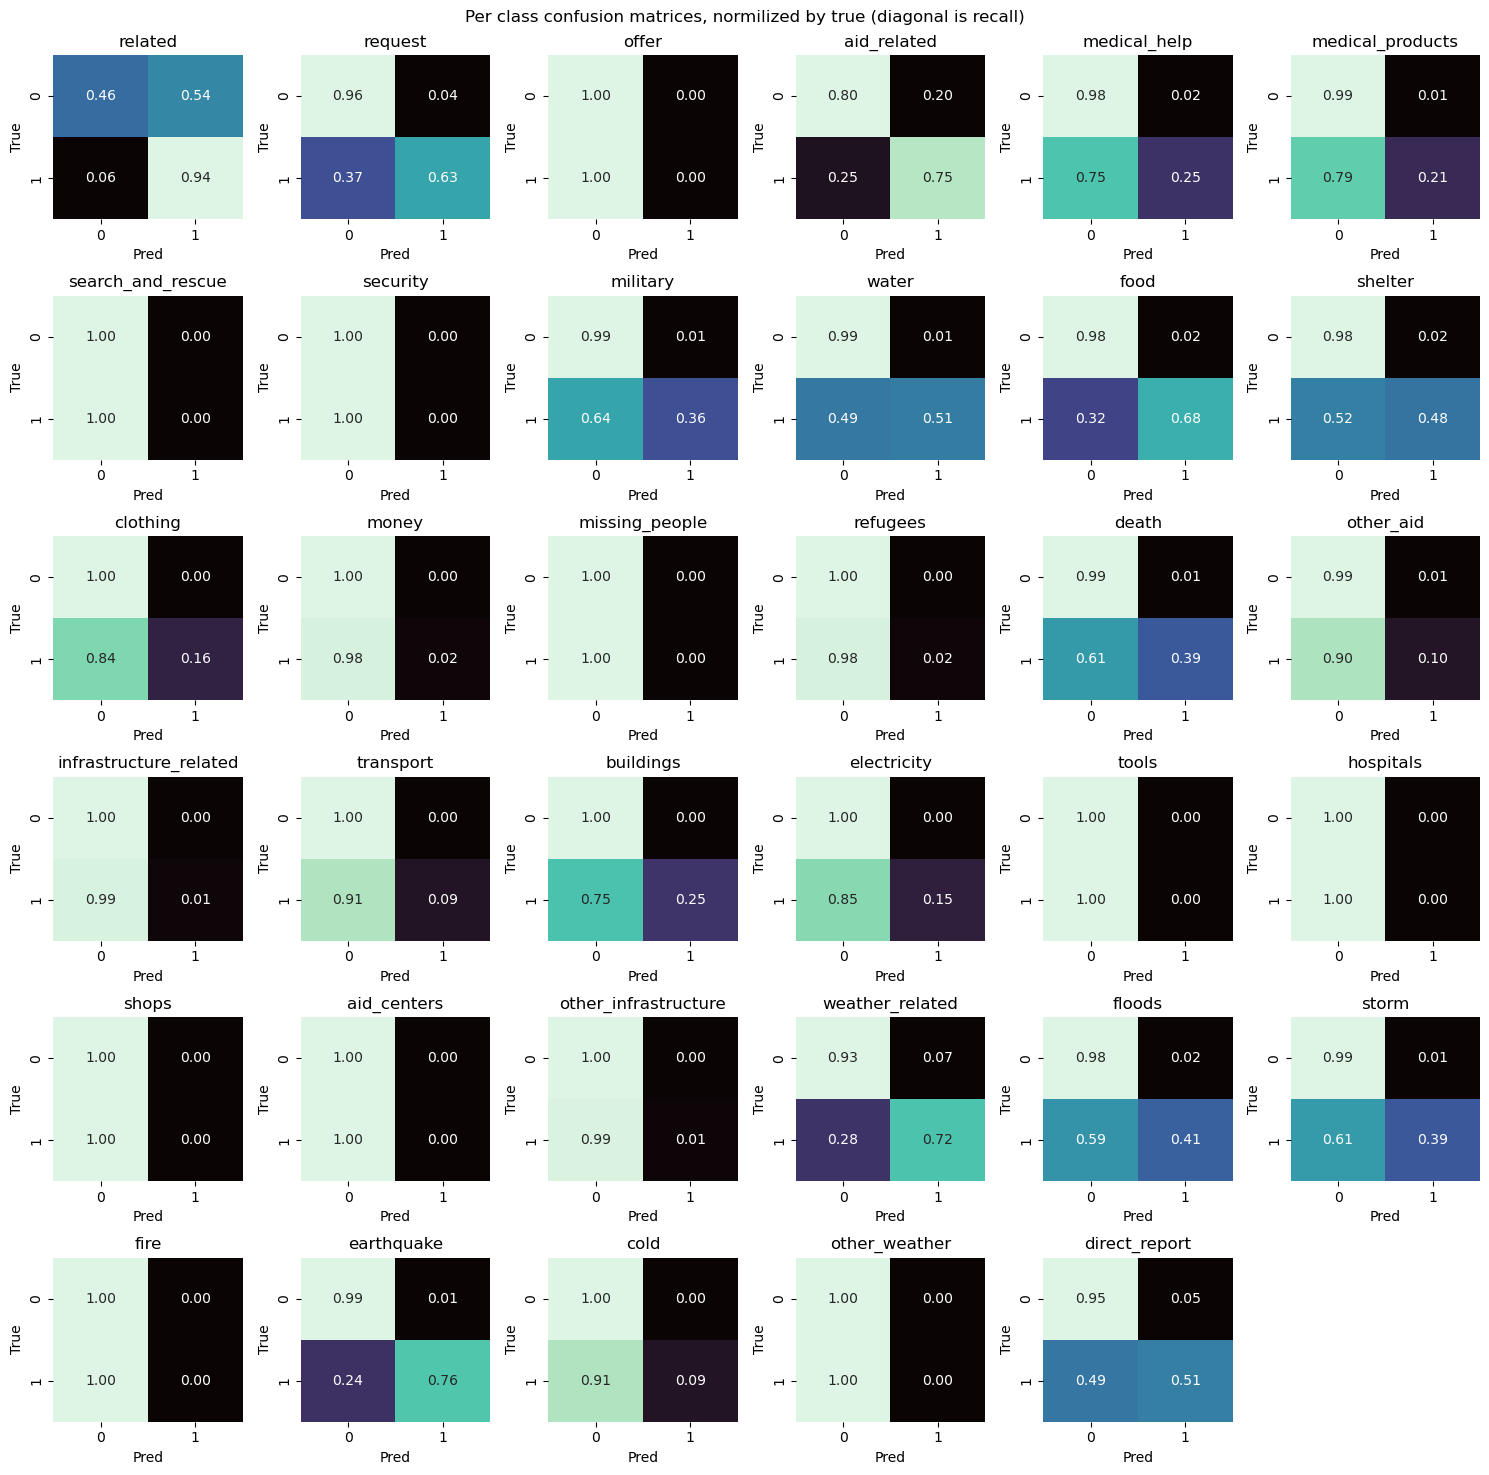

In [14]:
results(history, 10,  "_2")
eval_model(embeddings_tests, y_test, label_names, model_lstm)

### Trainable embeddings

In [15]:
from sklearn.model_selection import train_test_split
texts = preprocessed_df["clean_text"].values
y = preprocessed_df[preprocessed_df.columns[3:-1]].to_numpy()
text_train, texts_test, y_train, y_test = train_test_split(texts, y, test_size=0.2, random_state=255)

In [16]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(8000, lower=False)
tokenizer.fit_on_texts(text_train)
text_train = tokenizer.texts_to_sequences(text_train)
texts_test = tokenizer.texts_to_sequences(texts_test)
text_train = tf.keras.preprocessing.sequence.pad_sequences(text_train, maxlen=50, padding="post")
texts_test =  tf.keras.preprocessing.sequence.pad_sequences(texts_test, maxlen=50, padding="post")

In [17]:
embeddings_trainable_train_tensors = tf.data.Dataset.from_tensor_slices((text_train, y_train)).batch(32).prefetch(tf.data.AUTOTUNE)
embeddings_trainable_test_tensors = tf.data.Dataset.from_tensor_slices((texts_test, y_test)).batch(32).prefetch(tf.data.AUTOTUNE)

In [18]:
model_lstm = lstm_model(text_train.shape, output_dim=y_train.shape[1], embedding_dim=50, vocabulary=8000)

In [19]:
model_lstm.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics = tf.keras.metrics.AUC(multi_label=True))
history = model_lstm.fit(embeddings_trainable_train_tensors, validation_data = embeddings_trainable_test_tensors , epochs = 5)

Epoch 1/5
656/656 [==============================] - 42s 49ms/step - loss: 0.2241 - auc_3: 0.6370 - val_loss: 0.1863 - val_auc_3: 0.7488
Epoch 2/5
656/656 [==============================] - 28s 42ms/step - loss: 0.1720 - auc_3: 0.7823 - val_loss: 0.1704 - val_auc_3: 0.7868
Epoch 3/5
656/656 [==============================] - 27s 41ms/step - loss: 0.1540 - auc_3: 0.8328 - val_loss: 0.1719 - val_auc_3: 0.7908
Epoch 4/5
656/656 [==============================] - 27s 41ms/step - loss: 0.1426 - auc_3: 0.8630 - val_loss: 0.1735 - val_auc_3: 0.7918
Epoch 5/5
656/656 [==============================] - 27s 42ms/step - loss: 0.1324 - auc_3: 0.8851 - val_loss: 0.1783 - val_auc_3: 0.7913


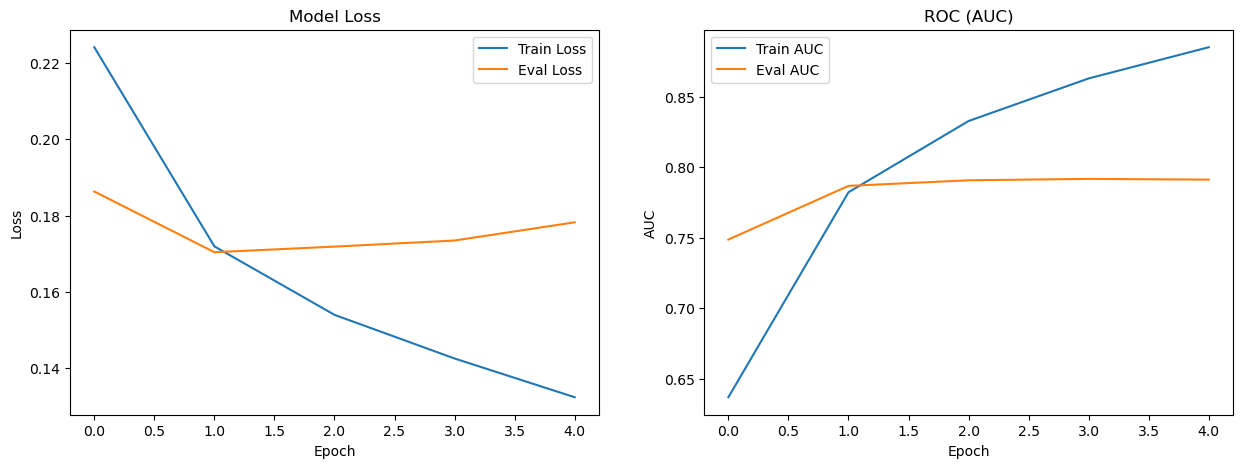

                        precision    recall  f1-score   support

               related       0.87      0.90      0.89      4018
               request       0.70      0.64      0.67       911
                 offer        nan      0.00      0.00        21
           aid_related       0.70      0.77      0.73      2232
          medical_help       0.37      0.17      0.24       438
      medical_products       0.44      0.22      0.29       265
     search_and_rescue        nan      0.00      0.00       152
              security        nan      0.00      0.00        82
              military       0.57      0.23      0.33       166
                 water       0.58      0.38      0.46       345
                  food       0.78      0.70      0.74       607
               shelter       0.67      0.52      0.59       465
              clothing        nan      0.00      0.00        82
                 money        nan      0.00      0.00       120
        missing_people        nan      

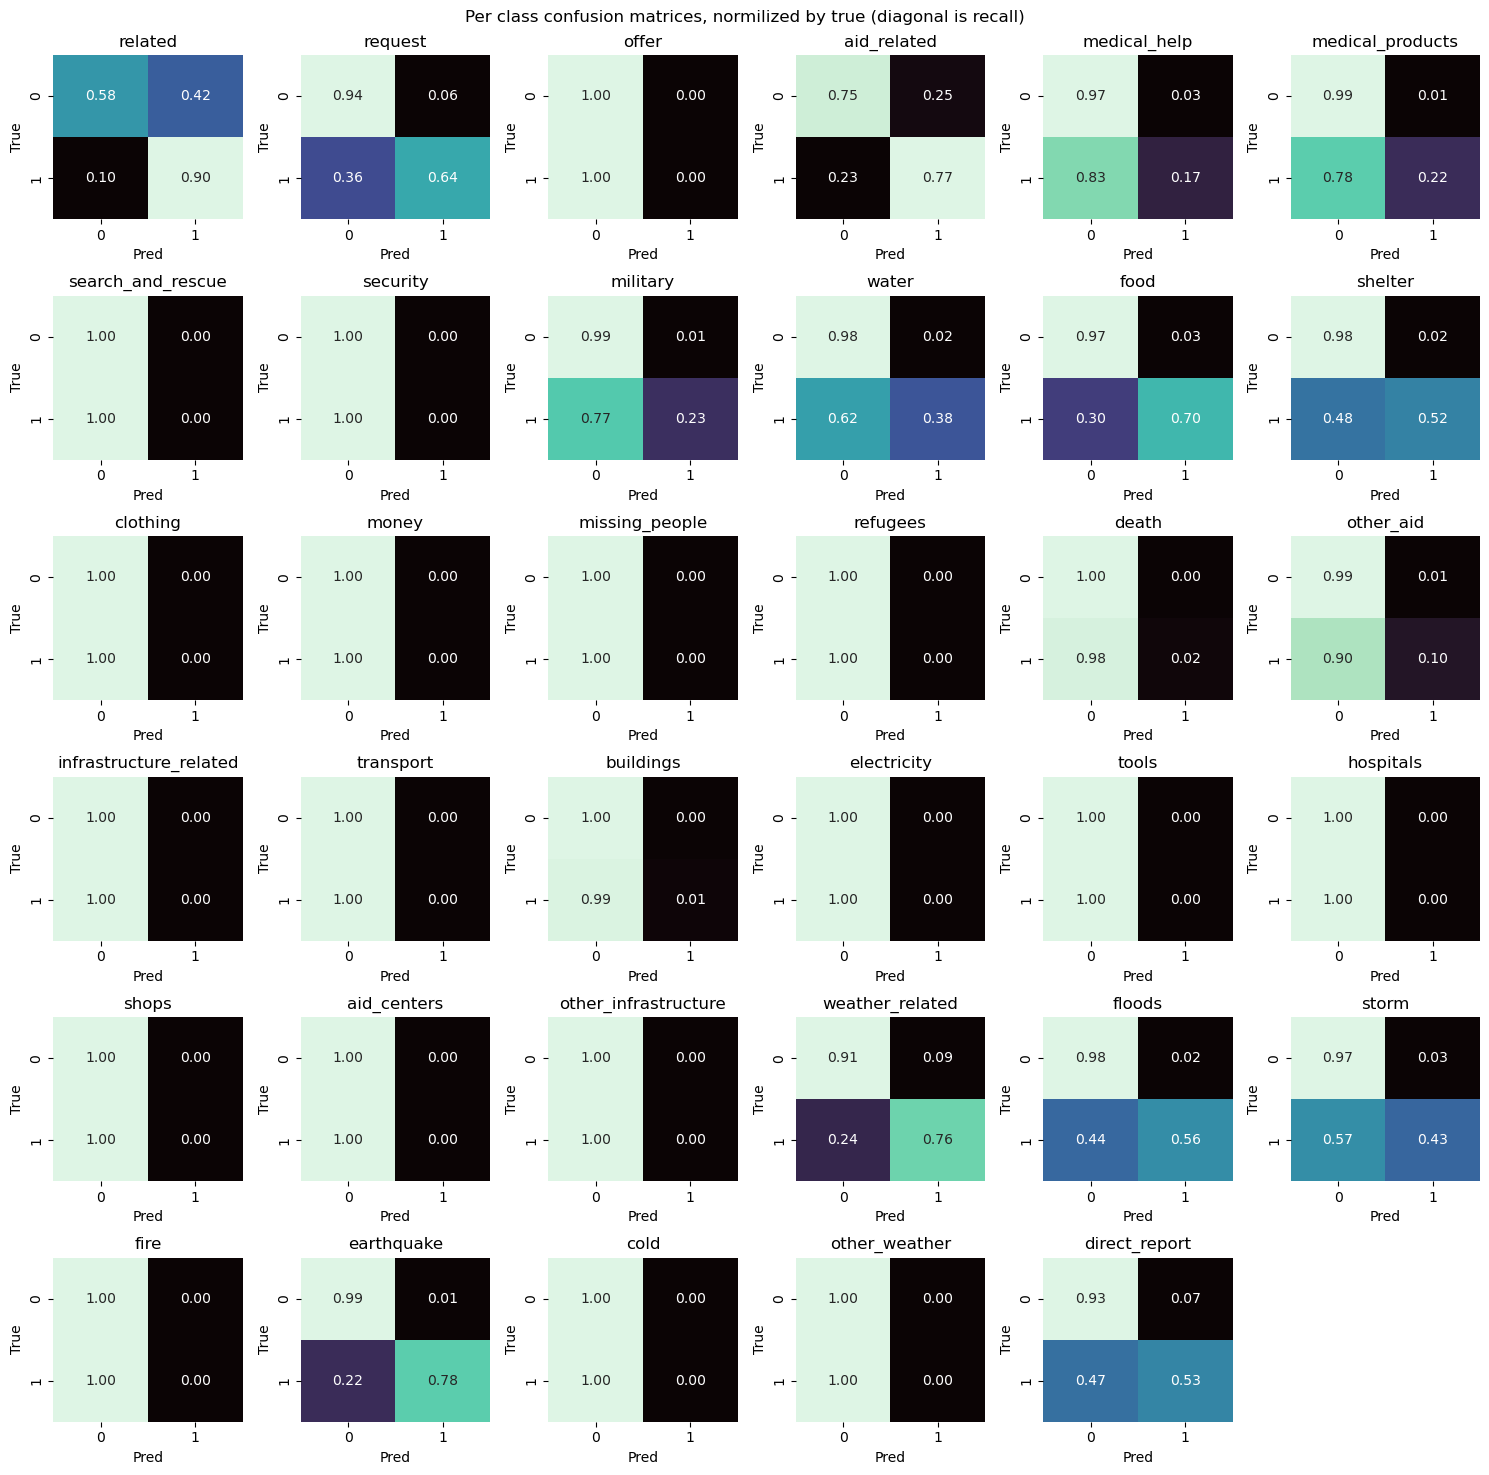

In [20]:
results(history, 5,  "_3")
eval_model(texts_test, y_test, label_names, model_lstm)

### Conclusion

Across all tested approaches, the linear dense network trained on TF-IDF features achieved the most balanced performance, with a macro-F1 score around 0.38 and a micro-F1 near 0.67, outperforming Word2Vec-based dense and LSTM models. This result shows the effectiveness of TF-IDF in capturing lexical cues that are highly indicative of specific disaster-related categories. On the other hand, models built on Word2Vec embeddings or trainable embedding layers underperformed, largely due to the dataset’s short message lengths, small vocabulary, and class imbalance. The LSTM architecture didn't provide any advantage, as most messages contain few tokens (while 99% is less than 50), offering little sequential information for the recurrent layers. Additionally, training word embeddings from scratch on such a small corpus leads to fast overfitting and weak generalization to rare labels. In overall, the findings demonstrate that traditional linear or shallow dense models remain highly competitive for small and short-text datasets, where deeper sequential architectures cannot leverage their full representational power.